In [1]:
import numpy as np
from scipy.constants import degree

from scipy.integrate import cumulative_trapezoid, solve_bvp

import matplotlib.pyplot as plt
import numpy as np
from ipywidgets import interact

params = {
    "figure.figsize": (6, 4),
    "figure.dpi": 72,
    "axes.titlesize": 14,
    "axes.labelsize": 14,
    "font.size": 14,
    "xtick.labelsize": 14,
    "ytick.labelsize": 14,
    "legend.fontsize": 14,
    "savefig.bbox": "tight",
    "figure.constrained_layout.use": True,
}
plt.rcParams.update(params)

%matplotlib widget

In [12]:
sqrt2 = np.sqrt(2)


class FallingCat:
    def __init__(self, JI, alpha, N=128, init=None):
        """
        Falling cat problem

        Args:
            JI: moment of intertia along cylinder axis divided by that perpendicular to it
            alpha: angle between K and A1 in fig2 of Kane & Scher
            N: number of mesh points in theta [0,2pi]
            init: initial guess as an FallingCat object
            if init is not None, N is not used
            outputs as properties of FallingCat object are:
            beta: angle between K and B1 in fig2 of Kane & Scher
            theta: angle between A3 and B3
                    as independent variable (shape(N,))
            psi: angle between spine plane and vertical plane
                as dependent variable (shape(N,))
            all angles are in radians
        """
        ca, sa = np.cos(alpha), np.sin(alpha)

        def fun(theta, psi, beta):
            """eq(5) of Kane and Scher"""
            cb, sb = np.cos(beta), np.sin(beta)
            ct = np.cos(theta)
            S = sqrt2 * (ca * sb + sa * cb * ct) * sb
            T = ca * cb - sa * sb * ct
            T1, T2 = 1 + T, 1 - T
            f = JI * S / T2 / (T2 + JI * T1) / np.sqrt(T1)
            return [f]

        def bc(ya, yb, p):  # boundary condition
            return np.r_[ya, yb - np.pi]

        if init is None:
            theta = np.linspace(0, 2 * np.pi, N)
            psi = [np.linspace(0, np.pi, N)]
            beta = [(alpha + np.pi) / 3]
        elif isinstance(init, FallingCat):
            theta = init.theta
            psi = [init.psi]
            beta = [init.beta]
        else:
            raise RuntimeError("bat init")

        self.sol = solve_bvp(fun, bc, theta, psi, beta)

        self.alpha = alpha
        self.theta = self.sol.x
        self.psi = self.sol.y[0]
        self.beta = self.sol.p[0]

    def bend(self, theta=None):
        """gamma = angle between A1 and B1
        in fig2 of Kane & Scher"""
        if theta is None:
            theta = self.theta
        ca, sa = np.cos(self.alpha), np.sin(self.alpha)
        cb, sb = np.cos(self.beta), np.sin(self.beta)
        return np.arccos(ca * cb - sa * sb * np.cos(theta))

    def twist(self, theta=None):
        """phi = angle of rotation along cylinder axis"""
        a, b, t = self.alpha, self.beta, self.theta
        ca, sa = np.cos(a), np.sin(a)
        cb, sb = np.cos(b), np.sin(b)
        T11 = ca * cb - sa * sb * np.sin(t)
        T12 = -ca * sb - sa * cb * np.cos(t)
        p = cumulative_trapezoid(T12 / (1 - T11**2), t, initial=0) * sb
        if theta is None:
            return p
        return np.interp(theta, t, p)

    def lean(self, theta=None):
        """psi = angle between spine plane and vertical plane"""
        if theta is None:
            return self.psi
        return np.interp(theta, self.theta, self.psi)

    def plot(self, ax, theta, length=5, N=32, color=None, leg_color=None, **kw):
        """
        Args:
            theta: angle between A3 and B3 in fig2 of Kane & Scher
            length: length of each cylinder
            N: number of mesh points on cylinder
            color: cylinder color (passed to Axes3D.plot_surface)
            leg_color: passed to Axes3D.plot
            kw: keyward arguments passed to Axes3D.plot
        """
        gam = self.bend(theta)
        phi = self.twist(theta)
        psi = self.lean(theta)
        cph, sph = np.cos(phi), np.sin(phi)
        cgm, sgm = np.cos(gam / 2), np.sin(gam / 2)
        cps, sps = np.cos(psi), np.sin(psi)

        # plot cylinders
        u, v = np.mgrid[0 : length : N * 1j, 0 : 2 * np.pi : N * 1j]

        # front cylinder
        y = -u
        z, x = np.cos(v), np.sin(v)
        y, z = y * cgm + z * sgm, -y * sgm + z * cgm
        z, x = z * cps - x * sps, z * sps + x * cps
        ax.plot_wireframe(x, y, z, color=color, alpha=0.5)

        # rear cylinder
        y = u
        z, x = np.cos(v), np.sin(v)
        y, z = y * cgm - z * sgm, y * sgm + z * cgm
        z, x = z * cps - x * sps, z * sps + x * cps
        ax.plot_wireframe(x, y, z, color=color, alpha=0.5)

        # plot legs
        u = np.asarray([1, 1]) * length / 2
        v = np.asarray([1, -1]) * np.pi / 12

        # front legs
        y = -u
        z, x = np.cos(v), np.sin(v)
        z, x = z * cph - x * sph, z * sph + x * cph
        y, z = y * cgm + z * sgm, -y * sgm + z * cgm
        z, x = z * cps - x * sps, z * sps + x * cps
        ax.scatter(x, y, z, c=leg_color, depthshade=False, **kw)

        # rear legs
        y = u
        z, x = np.cos(v), np.sin(v)
        z, x = z * cph - x * sph, z * sph + x * cph
        y, z = y * cgm - z * sgm, y * sgm + z * cgm
        z, x = z * cps - x * sps, z * sps + x * cps
        ax.scatter(x, y, z, c=leg_color, depthshade=False, **kw)

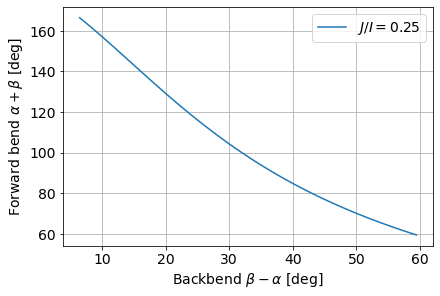

In [13]:
JI = [0.25]
# alpha = np.linspace(36, 82, 50) * degree
alpha = np.linspace(0, 80, 101) * degree

plt.close("all")

for j in JI:
    beta, c = [], None
    for a in alpha:
        c = FallingCat(j, a, init=c)
        beta.append(c.beta)

    ba = (beta - alpha) / degree
    ab = (alpha + beta) / degree
    plt.plot(ba, ab, label="$J/I=%g$" % j)

plt.gcf().canvas.header_visible = False
plt.gcf().canvas.footer_visible = False

plt.legend()
plt.xlabel(r"Backbend $\beta - \alpha$ [deg]")
plt.ylabel(r"Forward bend $\alpha + \beta$ [deg]")
plt.grid()

plt.show()

interactive(children=(FloatSlider(value=0.25, description='JI', max=0.5, min=0.1, step=0.01), IntSlider(value=…

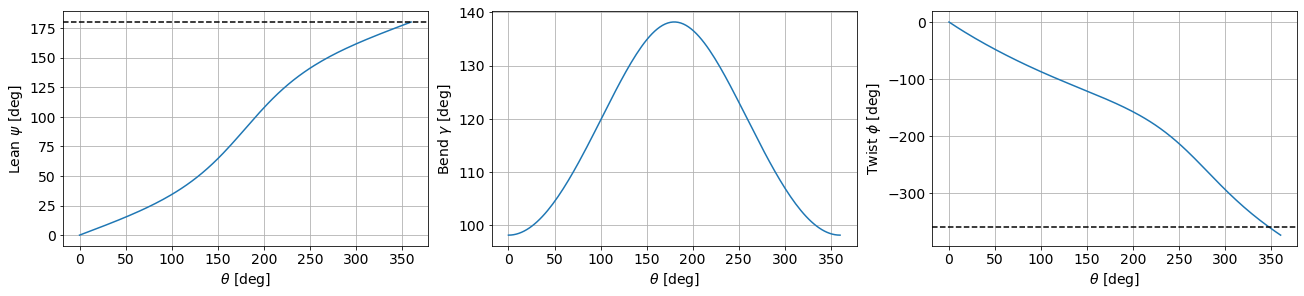

In [21]:
fig, ax = plt.subplots(1, 3, figsize=(18, 4))
fig.canvas.header_visible = False
fig.canvas.footer_visible = False


def plot_rotations(JI=0.25, alpha=20):
    c = FallingCat(JI, alpha * degree)

    t = c.theta / degree
    psi = c.lean() / degree
    gamma = 180 - c.bend() / degree
    phi = c.twist() / degree

    # print(phi[-1])
    # print((c.alpha + c.beta) / degree)
    # print((c.beta - c.alpha) / degree)

    ax[0].cla()
    ax[0].plot(t, psi)
    ax[0].axhline(180, color="k", linestyle="--")
    ax[0].set_xlabel(r"$\theta$ [deg]")
    ax[0].set_ylabel(r"Lean $\psi$ [deg]")
    ax[0].grid()

    ax[1].cla()
    ax[1].plot(t, gamma)
    ax[1].set_xlabel(r"$\theta$ [deg]")
    ax[1].set_ylabel(r"Bend $\gamma$ [deg]")
    ax[1].grid()

    ax[2].cla()
    ax[2].plot(t, phi)
    ax[2].axhline(-360, color="k", linestyle="--")
    ax[2].set_xlabel(r"$\theta$ [deg]")
    ax[2].set_ylabel(r"Twist $\phi$ [deg]")
    ax[2].grid()


interact(plot_rotations, JI=(0.1, 0.5, 0.01), alpha=(0, 60, 1));

interactive(children=(FloatSlider(value=0.25, description='JI', max=0.5, min=0.1, step=0.01), IntSlider(value=…

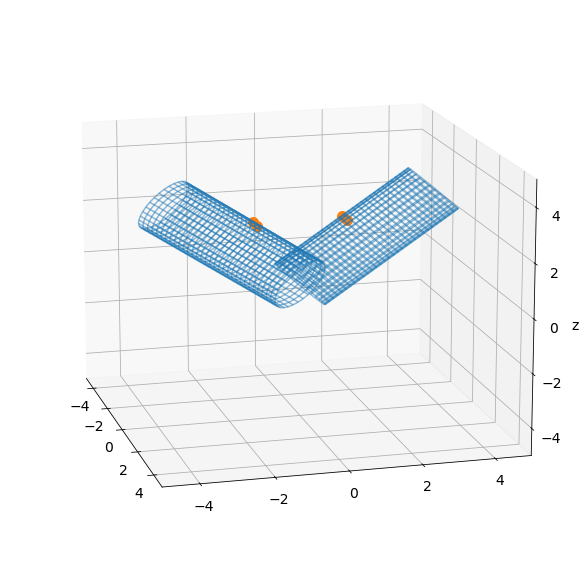

In [22]:
fig, ax = plt.subplots(figsize=(12, 8), subplot_kw={"projection": "3d"})
fig.canvas.header_visible = False
fig.canvas.footer_visible = False
ax.autoscale(False)
ax.axis("equal")
ax.view_init(15, -15)


def plot_cat(JI=0.25, alpha=20, theta=0):
    c = FallingCat(JI, alpha * degree)

    ax.cla()
    c.plot(ax, theta, length=5, N=32, color="C0", leg_color="C1", marker="o", s=100)
    ax.set_xlim(-5, 5)
    ax.set_ylim(-5, 5)
    ax.set_zlim(-5, 5)
    ax.set_zlabel("z")


interact(plot_cat, JI=(0.1, 0.5, 0.01), alpha=(0, 60, 1), theta=(0, 2 * np.pi, 0.1));